In [101]:
from __future__ import division
from  imageio import imwrite 
%pylab inline
import numpy as np
import scipy as sp
import scipy.fftpack as ft


Populating the interactive namespace from numpy and matplotlib


(128, 128, 3)
mean:  136.9349365234375 
standart deviation:  55.59281495266457 
valeur min:  1.0
im shape (128, 128)


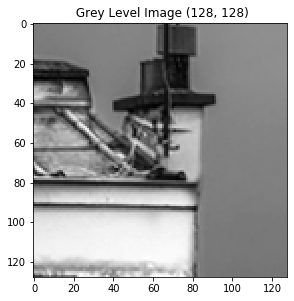

In [102]:
size_R_patch = 10
half_taille_patch = 3
Dim_PCA = 25
COEF_k = 0.4
# load an image
import imageio as imio
colored_image = imio.imread('toit.PNG')
print(colored_image.shape)
n = colored_image.shape[0] - 1
n = 128
image = np.sum(colored_image * [0.21, 0.72 ,0.07],axis=-1)

plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.gray()
plt.title(" Grey Level Image " + str(np.shape(image)))
cropped = image
plt.imshow(image)
print("mean: ", np.mean(cropped), "\nstandart deviation: ", np.std(cropped), "\nvaleur min: ", (np.min(cropped)))
print("im shape", image.shape)
image0 = np.copy(image)

### We define the snr and several types of noise.

-0.0


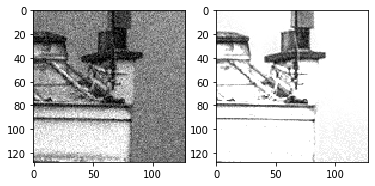

In [103]:
def snr(x, y): # signal noise ratio
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) / s)

def clamp0(x):
    temp = 255 * (x > 255) + x * (x < 255) 
    return temp * (x > 0)

def clamp(x, a, b):
    temp = b *(x > b) + x * (x < b)  
    result = temp * (temp > a) + a * (x < a)
    return result

def GaussianNoise(image, sigma):
    return clamp0(image + sigma * np.random.randn(image.shape[0], image.shape[1]))

def SaltNoise(image, sigma):
    return clamp0(image + sigma * (np.random.randn(image.shape[0], image.shape[1]) > 0))

sigma = 20.0
noisy_image = clamp0(image + sigma * np.random.randn(image.shape[0], image.shape[1]))
noisy_salt = clamp0(image + SaltNoise(image, 30))
print(np.min(noisy_image))
plt.subplot(1, 2, 1)
plt.imshow(noisy_image)
plt.subplot(1, 2, 2)
plt.imshow(noisy_salt)

### In the cell below, we construct an array that codes for the coordinates of the patches.

In [104]:
taille_patch = 2 * half_taille_patch + 1
[X, Y, dX, dY] = np.meshgrid(np.arange(1, n + 1), np.arange(1, n + 1), np.arange(-half_taille_patch, half_taille_patch + 1), np.arange(-half_taille_patch, half_taille_patch + 1))
print(dY) 
# X est une range 0-127 de 1 puis 2 [...] jusqu'à N et ensuite on rajoute dX une range -3;3 (-N;N)
# X représente les coefs par lignes
# de même pour Y les coefs par lignes et dY

X = X + dX # x coordinate
Y = Y + dY # y coordinate
# hereafter we deal with the boundaries.
X[X < 1] = 2 - X[X < 1] #miroir sur X[i<0]
Y[Y < 1] = 2 - Y[Y < 1] #miroir sur Y[i<10]
X[X > n] = 2 * n - X[X > n] #miroir sur X[i>n]
Y[Y > n] = 2 * n - Y[Y > n] #miroir sur X[i>n]
#print(np.meshgrid(np.arange(1,4),np.arange(1,4)))
#print(X[120][127])
print(X[0][0])


[[[[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  ...

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]]


 [[[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  ...

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]]


 [[[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  ...

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]]


 ...


 [[[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  [[-1  0  1]
   [-1  0  1]
   [-1  0  1]]

  ...

  [[-1  0  1]
   [-1  0  1]
   [-1 

### Dans le cas ou on est sur les bords ici le choix à été de faire un miroir des pixels ce situant sur les bords.

### We collect the patches below using $I$ which collects the coordinates defining the patches.

In [105]:
I = (X-1) + (Y-1)*n
print("size of the array I ",I.shape)
for i in range(n//half_taille_patch): # // division entière
    for j in range(n//half_taille_patch):
        I[i,j] = np.transpose(I[i,j])
        #print(I[i,j],"\n")
patch = lambda f: np.ravel(f)[I] #ravel: concatenation
P = patch(noisy_image)
#P = patch(image )

# on applique la décomposition par patch I à l'image qui est d'abord concaténé.


size of the array I  (128, 128, 3, 3)


### Determination du sigma

128 128
sigma tot image 623.8574188967108


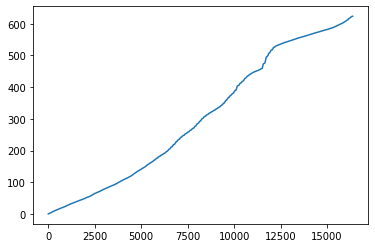

128 128
nb_minsigma : 1638
sigma_noise_estim : 21.492005098181803


In [106]:
nb_x = image.shape[0]
nb_y = image.shape[1]
print(nb_x,nb_y)
count_patch =0 
sigma_estim=0
sigma_tab = [0]*nb_x*nb_y
for i in range(0,nb_x):
    for j in range(0,nb_y):
        #print(P[i,j])
        sigma_estim += np.mean(( P[i,j] - np.ones(np.uint32(taille_patch),np.uint32(taille_patch))*np.mean(P[i,j])) **2  )      
        sigma_tab[count_patch] = sigma_estim
        
        count_patch+=1
sigma_estim = sigma_estim/count_patch
sigma_tab = sigma_tab/(np.ones(np.shape(sigma_tab))*count_patch)
print("sigma tot image", sigma_estim)
plt.plot(sigma_tab)
plt.show()
print( nb_x, nb_y)
nb_minsigma = np.uint32(len(sigma_tab)*0.1) 
#On prend 10% des sigma les plus faibles pour estimer le sigma du bruit
print("nb_minsigma :",nb_minsigma)

sigma_noise_estim = 0
max_tab = np.max(sigma_tab)
#print(np.where(sigma_tab==np.min(sigma_tab)))
for i in range(0,nb_minsigma):
    
    it_min = np.argwhere(sigma_tab==np.min(sigma_tab))
    minloc = np.min(sigma_tab)
    sigma_tab[it_min] = max_tab
    sigma_noise_estim += minloc
   # print(sigma_tab[i])

sigma_noise_estim = sigma_noise_estim / nb_minsigma
print("sigma_noise_estim :",sigma_noise_estim)

### Question 1: what happens for the patches on the boundary of the image for the patches ?

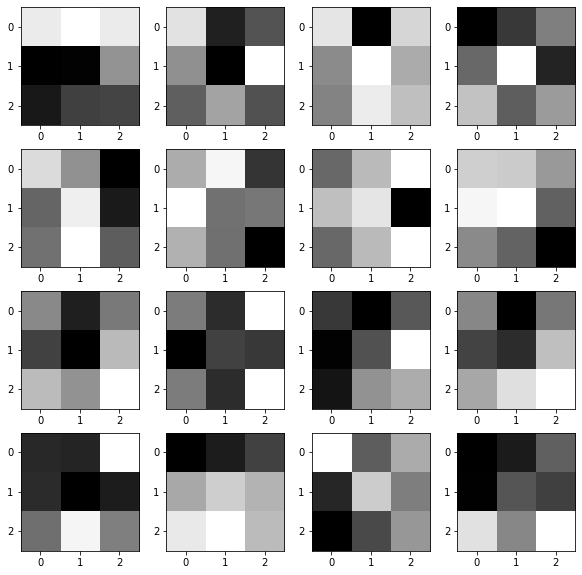

Patch en I[0,0]


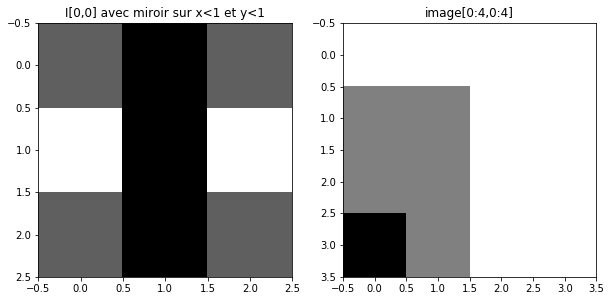

In [107]:
### some random patches.
plt.figure(figsize = (10,10))
for i in range(16):
    x = np.random.randint(n)
    y = np.random.randint(n)
    plt.subplot(4,4,i+1)
    plt.imshow(P[x, y])
#plt.imshow(P[127, 127])
#plt.show()
#plt.figure(figsize = (10,10))
#plt.imshow(P[127, 0])
plt.show()
print("Patch en I[0,0]")
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.title("I[0,0] avec miroir sur x<1 et y<1")
plt.imshow(P[0,0])
plt.subplot(1,2,2)
plt.title("image[0:4,0:4]")
plt.imshow(image[0:4,0:4])
plt.show()

## 2. Dimensionality reduction using PCA: Principal Component Analysis.
We have collected a large number of patches and we would like to represent this collection of patches by a simple known distribution that approximates it. The PCA method uses a gaussian approximation. Note that the size of a patch is $6^2$ or $8^2$, so that we want to reduce the dimension to $15$ or a bit more.
The PCA algorithm finds a linear subspace of dimension $k$, which is chosen by the user, that minimizes the distances of data with respect to this subspace.

In [108]:
dimension = Dim_PCA
# a reshape function
resh = lambda P: np.transpose((np.reshape(P, (n*n,taille_patch**2), order="F")))
# remove mean is a preparation for PCA.
remove_mean = lambda Q: Q - np.tile(np.mean(Q,0),(taille_patch**2,1))
# np.tile :Construct an array by repeating A the number of times given by reps.
# np.mean(Q,axis=0) axis==0 -> a = np.array([[1, 2], [3, 4]]) -> array([2., 3.])
#                   axis==1 -> array([1.5, 3.5])
P1 = remove_mean(resh(P)) # P = patch(image) 
C = np.dot(P1,np.transpose(P1))

#### What is used below is a method in linear algebra called Singular Value Decomposition «SVD», and gives the subspaces being spanned by the first $k$ eigenvectors corresponding to the $k$ largest eigenvalues of the decomposition. 

In [109]:
[D,V] = np.linalg.eig(C)
# the array D is the list of eigenvalues and the arry V is the corresponding eigenvectors.
# We then sort the values in decreasing order and reindex the corresponding eigenvectors.
D = np.sort(D)[::-1] #eingenvalues sorted
I = np.argsort(D)[::-1] # argosort renvoie la position des egeinvalue sorted
V = V[I,:] # renvoie les eigein vecteur en fonction de la valeur décroissante des eigeinvalue
# L = range(10)
#L[::-1] -> [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


### Eigenvector and EigenValue of PCA

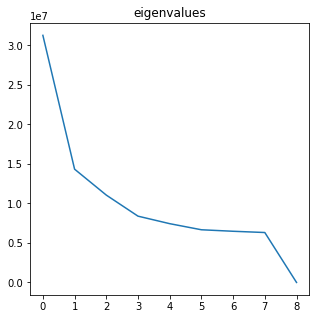

In [110]:
plt.figure(figsize = (5,5))
plt.title("eigenvalues")
plt.plot(D)

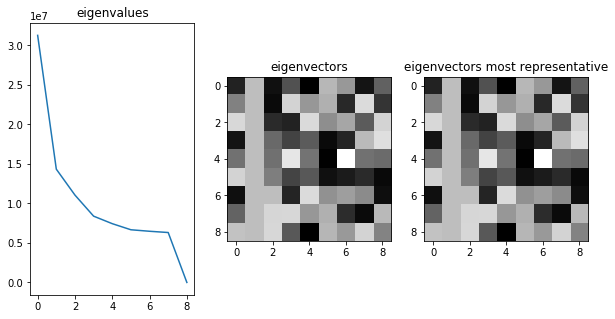

In [111]:
plt.figure(figsize = (10,5))
plt.subplot(1,3,1)
plt.title("eigenvalues")
plt.plot(D)
plt.subplot(1,3,2)
plt.title("eigenvectors")
plt.imshow(V)
MainEigenvalues = V[0:10]
plt.subplot(1,3,3)
plt.title("eigenvectors most representative")
plt.imshow(MainEigenvalues)
plt.show()


In [112]:
iresh = lambda Q: np.reshape(np.transpose(Q),(n,n,dimension),order="F")
H = iresh(np.dot(np.transpose(V[: ,:dimension]),remove_mean(resh(P)))) #pscalair V et P reshape
print (np.transpose(V[: ,:dimension]).shape,remove_mean(resh(P)).shape)
print (H.shape)
#dimension =25

ValueError: cannot reshape array of size 147456 into shape (128,128,25)

In [ ]:
# Selection of the parameter that select a range of patches in order to fasten the computations so in fact 
# the algorithm is a bit more local...
f = size_R_patch

In [ ]:
selection = lambda i: np.array((clamp(np.arange(i[0]-f,i[0] + f + 1), 0, n-1), clamp(np.arange(i[1]-f,i[1] + f + 1), 0, n-1)))
# on vient regarder non plus toute l'image mais une range de -f à f dans laquel on regarde les patchs
# sinon sur toute l'image la complexité est trop importante

In [ ]:
def distance_0(i,sel): 
    H1 = (H[sel[0],:,:])
    H2 = (H1[:,sel[1],:])
    return np.sum((H2 - np.tile(H[i[0],i[1],:],(len(sel[0]),len(sel[1]),1)))**2,2)/(taille_patch**2)

#   b = np.array([[1, 2], [3, 4]])
#   np.tile(b, 2)
#   array([[1, 2, 1, 2],
#          [3, 4, 3, 4]])

normalize = lambda K: K/np.sum(K)
distance = lambda i: distance_0(i, selection(i))
kernel = lambda i, tau: normalize(np.exp(-distance(i)/ (2*tau**2)))


In [ ]:
tau = 10
i = [85,40]
D = distance(i)
K = kernel(i, tau)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(D)
plt.subplot(1,2,2)
plt.imshow(K)
plt.show()

In [ ]:
def NLval_0(K,sel): 
    f_temp = noisy_image[sel[0],:]
    return np.sum(K*f_temp[:, sel[1]]) #mutltiplication kernel * noisy image

NLval = lambda i, tau: NLval_0(kernel(i, tau), selection(i))

#### Question 4: Understand the code below.

In [ ]:
[Y, X] = np.meshgrid(np.arange(0,n),np.arange(0,n)) #rappel n = 128 taille de l'image
#print(X) #0- 128 sur 128 collone / Y 0-128 sur 128 ligne
#meshgrid permet de construire des matrices ou tableau 2D a partir de range
def arrayfun(img,X,Y):
    n = len(X)
    p = len(Y)
    R = np.zeros([n,p])
    for k in range(n):
        for l in range(p):
            R[k,l] = img(k,l)
    return R

NLmeans = lambda tau: arrayfun(lambda i1, i2: NLval([i1,i2], tau), X, Y)
#rangetau=30
#snr_result=[0]*rangetau
#for tau in range(0,rangetau):
#    imgdenoised = NLmeans(tau)
#    snr_= snr(image,imgdenoised)
#    print("snr(image,imgdenoised) (tau =",tau,"): " ,snr_)
#    snr_result[tau]=snr_
tau=7
imgdenoised = NLmeans(tau)
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(noisy_image)
plt.subplot(1,3,3)
plt.imshow(imgdenoised)
print("tau= ", tau ,"r=",half_taille_patch," f= ",f," sigma= ",sigma," snr(image,imgdenoised) = ",snr(image,imgdenoised))
plt.show()

tau2=COEF_k*sigma
imgdenoised2 = NLmeans(tau2)
plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(noisy_image)
plt.subplot(1,3,3)
plt.imshow(imgdenoised2)
#inversion f et r d'ou f= half_t_patch  et r = f
print("tau= ", tau2 ,"f=",half_taille_patch," r= ",f," sigma= ",sigma," snr(image,imgdenoised) = ",snr(image,imgdenoised2))
plt.show()

[nan, 17.603420506790165, 17.60348645246212, 17.628698058826394, 18.09902566336656, 19.485562606281714, 20.524547388912815, 20.89116719773836, 20.840756643729662, 20.507749029720177, 19.986709570050067, 19.35965751537526, 18.70772789177049, 18.093437574333482, 17.548155512930382, 17.077708683058127, 16.676387324959762, 16.336519697046693, 16.049464801987522, 15.805454809141121, 15.594835739600352, 15.40939723061947, 15.242965351832154, 15.09131828176534, 14.951759156349231, 14.822620775202108, 14.702849258393996, 14.591713275067661, 14.4886288419255, 14.393068400979153] <br/>

Pour tau allant de 0 a 30

In [ ]:
snr_result=[ 17.603420506790165, 17.60348645246212, 17.628698058826394, 18.09902566336656, 19.485562606281714, 20.524547388912815, 20.89116719773836, 20.840756643729662, 20.507749029720177, 19.986709570050067, 19.35965751537526, 18.70772789177049, 18.093437574333482, 17.548155512930382, 17.077708683058127, 16.676387324959762, 16.336519697046693, 16.049464801987522, 15.805454809141121, 15.594835739600352, 15.40939723061947, 15.242965351832154, 15.09131828176534, 14.951759156349231, 14.822620775202108, 14.702849258393996, 14.591713275067661, 14.4886288419255, 14.393068400979153]
print("Max pour tau = " ,np.argmax(snr_result)+1 ," -> snr =" ,np.max(snr_result))
plt.plot(snr_result)
plt.title("SNR / tau")
plt.xlabel("h = k*sigma")
plt.ylabel("SNR")
print( "tau pris à 7 contre dans l'article -> tau= 0.4*sigma(=", sigma ,") : ",0.4*sigma)
print("r : taille du patch  des q(i,j) et f= taille de la recherche recherche autour du pixel p(x,y)")
print("r=3 , q=14, sigma=20")


In [ ]:
plt.imshow(noisy_image-imgdenoised2)
print("mean: ",abs(mean(noisy_image-imgdenoised2)))

In [118]:
image_denoise = imio.imread('toit_denoise.png') 
# résultat algorithme de A. Buades et al. 

25.5977868506471
mean:  0.5189555680285861


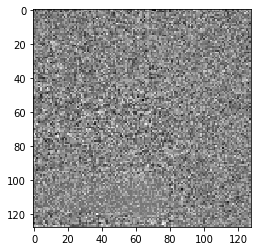

In [127]:
plt.imshow(image_denoise-noisy_image)
print(snr(image,image_denoise))
print("mean: ",mean(image_denoise-noisy_image))

In [ ]:
#f = size_R_patch-5
#tau =7
#snr_result=[0]*10
#count = 0
#for i in range(size_R_patch-5,size_R_patch+5):
#    f = i
#    imgdenoised = NLmeans(tau)
#    snr_= snr(image,imgdenoised)
#    print("snr(image,imgdenoised) (tau =",tau,"): " ,snr_)
#    snr_result[count]=snr_


[21.166305713050726, 21.38978060265473, 21.55147689589683, 21.633889091008207, 21.639833961319752, 21.59107465254273, 21.465195075298364, 21.297825601146943, 21.07387530476735, 20.799827513980958]


Text(0, 0.5, 'SNR')

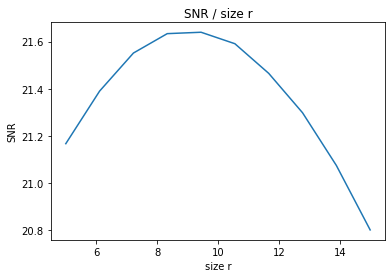

In [115]:
#### SNR pour des tailles r différentes
snr_result = [21.166305713050726,21.38978060265473,21.55147689589683,21.633889091008207,21.639833961319752,21.59107465254273,21.465195075298364,21.297825601146943,21.07387530476735,20.799827513980958]
print(snr_result)
plt.plot( np.linspace(size_R_patch-5,size_R_patch+5,10),snr_result, label= "snr_result/size f")
plt.title("SNR / size r")
plt.xlabel("size r")
plt.ylabel("SNR")

[16.158718446134152, 21.018707285848365, 21.695953088534047, 21.46268979045054, 21.085746381790674, 20.824141727677585, 20.629244109616973, 20.47402876059803, 20.32350091267268, 20.222451146755365]


Text(0, 0.5, 'SNR')

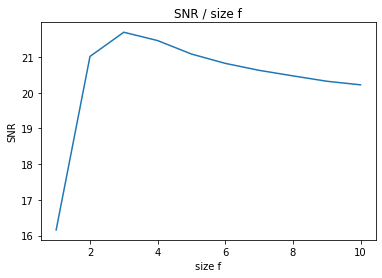

In [116]:
#### SNR pour des tailles f différentes
snr_result = [16.158718446134152, 21.018707285848365, 21.695953088534047, 21.46268979045054, 21.085746381790674, 20.824141727677585, 20.629244109616973, 20.47402876059803, 20.32350091267268, 20.222451146755365]
print(snr_result)
plt.plot( np.linspace(1,10,10),snr_result, label= "snr_result/size f")
plt.title("SNR / size f")
plt.xlabel("size f")
plt.ylabel("SNR")